In [2]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import time
import xarray as xr
from math import sqrt
import scipy.stats as stats
from scipy import optimize
import matplotlib.colors as colors
from numpy.random import Generator, PCG64
import matplotlib.dates as mdates
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from geopy import Point
from geopy.distance import distance
from geopy import units
from IPython.display import clear_output, display
import random
import pickle
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format='retina'
rng = Generator(PCG64(seed=0))
#Sort the file paths to get months in order
file_paths = sorted(glob.glob("ERA5_CF_2020*.nc"))

#Check if sorted
for file_path in file_paths:
    print(file_path)
ds = xr.open_mfdataset(file_paths) #all months of 2020
print(ds)



/Users/mustafamajid/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


ERA5_CF_202001.nc
ERA5_CF_202002.nc
ERA5_CF_202003.nc
ERA5_CF_202004.nc
ERA5_CF_202005.nc
ERA5_CF_202006.nc
ERA5_CF_202007.nc
ERA5_CF_202008.nc
ERA5_CF_202009.nc
ERA5_CF_202010.nc
ERA5_CF_202011.nc
ERA5_CF_202012.nc
<xarray.Dataset>
Dimensions:     (latitude: 201, longitude: 445, time: 8784)
Coordinates:
  * longitude   (longitude) float32 -31.0 -30.75 -30.5 ... 79.5 79.75 80.0
  * latitude    (latitude) float32 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * time        (time) datetime64[ns] 2020-01-01 ... 2020-12-31T23:00:00
Data variables:
    solarCF     (time, latitude, longitude) float32 dask.array<chunksize=(744, 201, 445), meta=np.ndarray>
    windCF_off  (time, latitude, longitude) float32 dask.array<chunksize=(744, 201, 445), meta=np.ndarray>
    windCF_on   (time, latitude, longitude) float32 dask.array<chunksize=(744, 201, 445), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-12-24 19:52:30 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...
    author:   

<h2>Handy Functions</h2>

In [3]:
#Find the (lat,lon) pair that actually exists in the dataset ds
def getActualCoords(lat, lon):
    lat_var = ds['latitude']
    lon_var = ds['longitude']

    #Get the lat,lon pair from the dataset
    actualpair = ds.sel(latitude=lat, longitude=lon,method='nearest')
    return (actualpair.latitude.values.item(), actualpair.longitude.values.item())

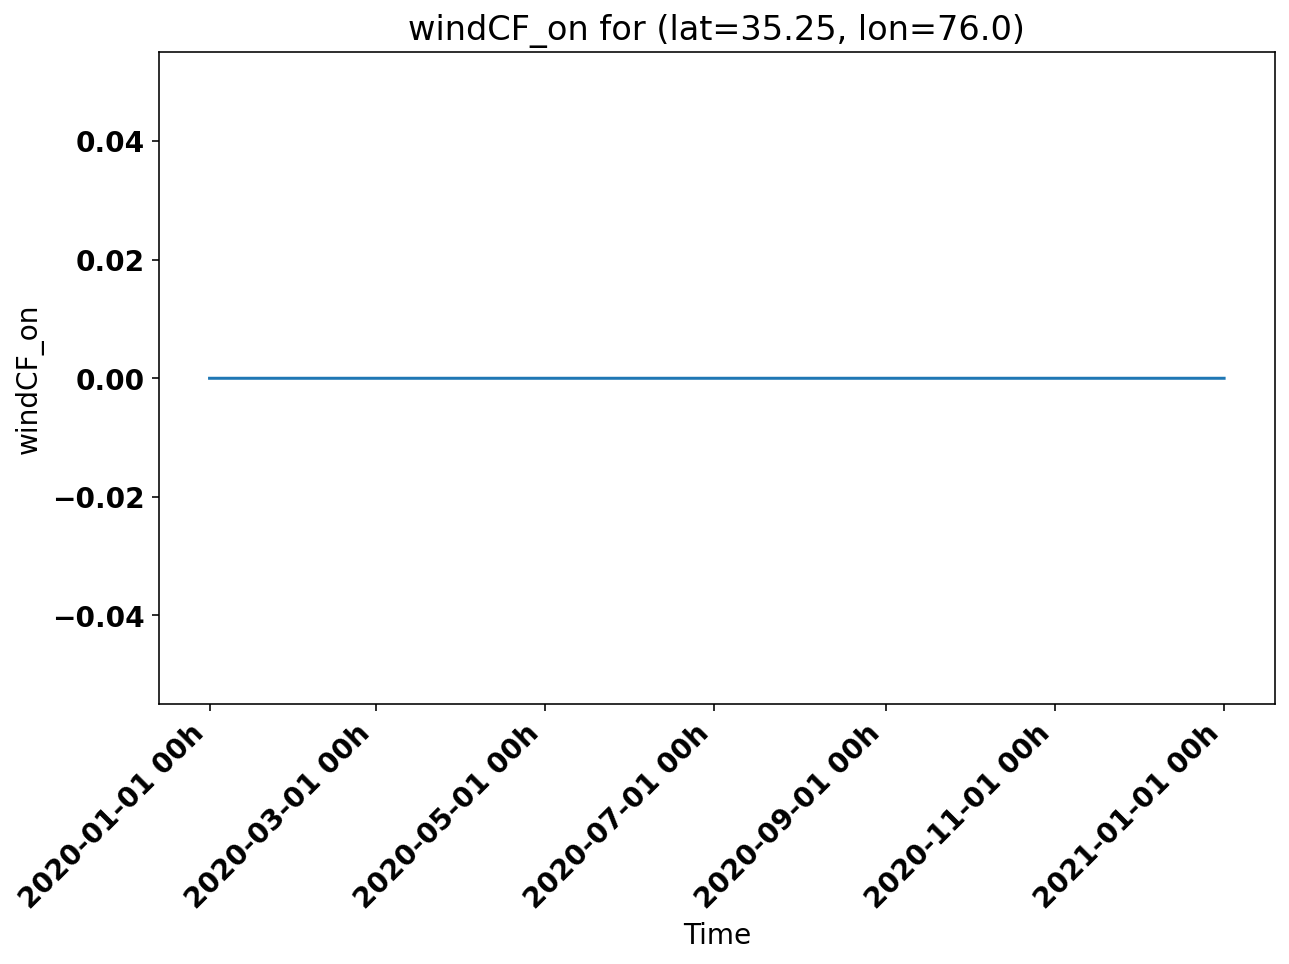

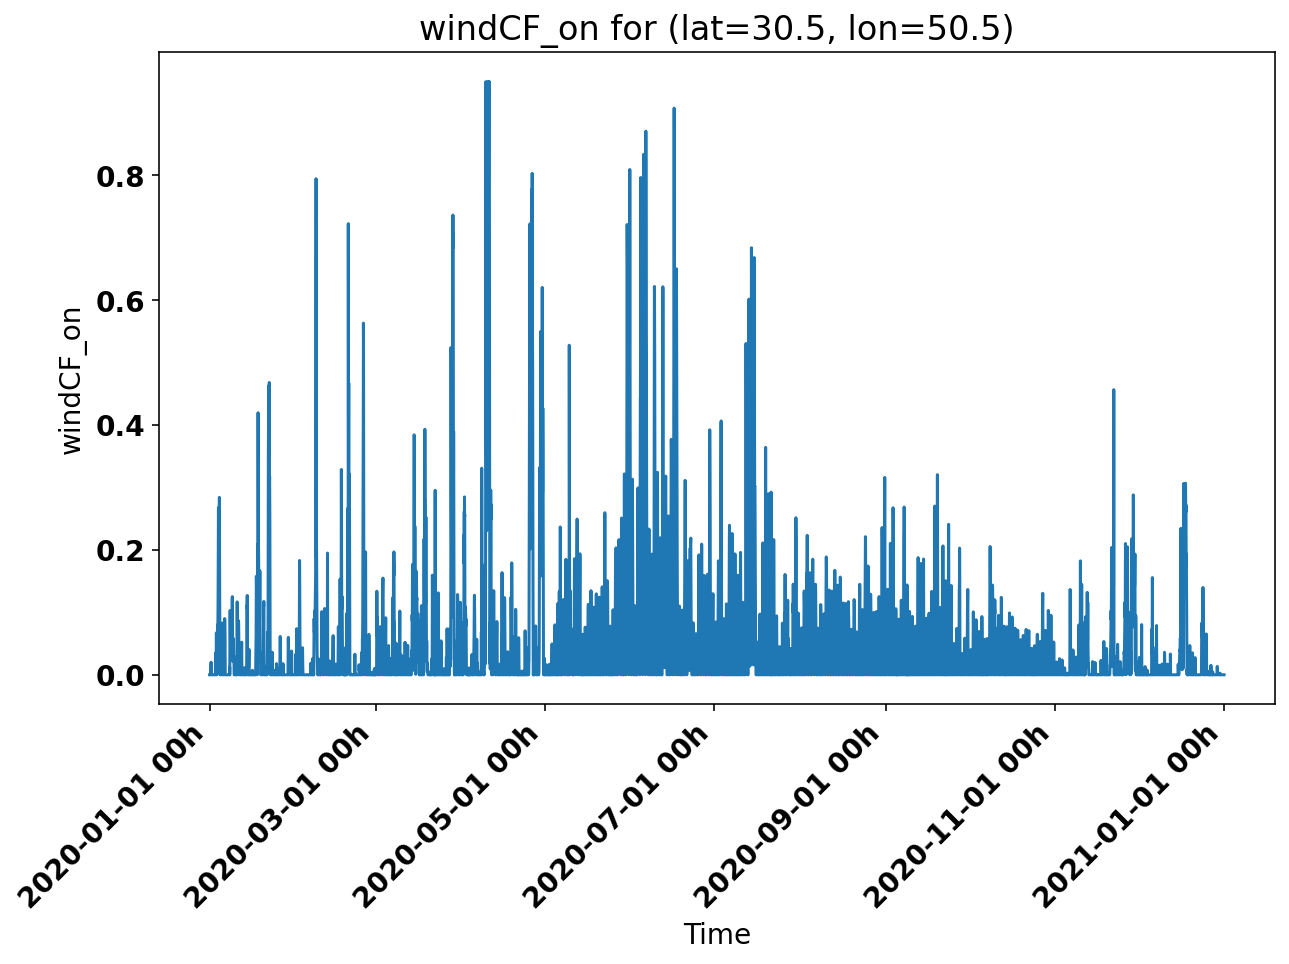

In [102]:
#Display the time series plot for a given location present in the ds
def plotCF(lat,lon):
    wind_cf_on = ds['windCF_on'].sel(latitude=lat, longitude=lon)

    fig, ax = plt.subplots(figsize=(10, 6))
    wind_cf_on.plot(ax=ax)
    plt.xticks(rotation=45, ha='right')
    #plt.xticks(pd.date_range(start=wind_cf_on.time.values[0], end=wind_cf_on.time.values[-1], freq='48H'))
    fig.patch.set_facecolor('white')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %Hh'))


    ax.set_title(f'windCF_on for (lat={lat}, lon={lon})')
    ax.set_xlabel('Time')
    ax.set_ylabel('windCF_on')
    display(fig)
    plt.close(fig)

plotCF(35.25,76.0)
plotCF(30.5,50.5)

In [5]:
solards = ds.solarCF.groupby(ds.time.dt.hour).max()
print(solards)

print(solards.sel(latitude= 52.0,longitude=5.0).values)

<xarray.DataArray 'solarCF' (hour: 24, latitude: 201, longitude: 445)>
dask.array<stack, shape=(24, 201, 445), dtype=float32, chunksize=(1, 201, 445), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 -31.0 -30.75 -30.5 -30.25 ... 79.5 79.75 80.0
  * latitude   (latitude) float32 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * hour       (hour) int64 0 1 2 3 4 5 6 7 8 9 ... 15 16 17 18 19 20 21 22 23
[4.0102897e-08 3.9961275e-08 4.0206139e-08 4.0263963e-08 8.1254272e-03
 8.3143324e-02 2.2236513e-01 3.6987984e-01 5.1279193e-01 6.3346630e-01
 7.2674596e-01 7.8524780e-01 8.0906582e-01 7.7710450e-01 7.4289995e-01
 6.6530615e-01 5.3913778e-01 4.0569898e-01 2.6804021e-01 1.2954730e-01
 2.8704472e-02 4.0215976e-08 3.9984396e-08 4.0234486e-08]


In [100]:
#Get the correlation between two time series at two locations (the same location for both inputs should give correlation 1).
#make another function before sampling where you check the hour with max solarcf for your selected origin location.
def pairCorrelation(loc1, loc2,somehour="any"): #,hours="any"
    #Extract solarCF data for loc1 and loc2
    #for solar, select hour as well in the parameters of .sel, and ds.time.dt.hour=hourformaxvalue, and use same hour of day for the sample points after getting the max
    if somehour == "any":
        cf1 = ds.windCF_on.sel(latitude=loc1[0], longitude=loc1[1])
        cf2 = ds.windCF_on.sel(latitude=loc2[0], longitude=loc2[1])
    else:
        cf1 = ds.windCF_on.sel(latitude=loc1[0], longitude=loc1[1])#, time.dt.hour=somehour)
        cf2 = ds.windCF_on.sel(latitude=loc2[0], longitude=loc2[1])        

    #Calculate the correlation coefficient between the two time series, and return the relevant value from the resulting matrix
    corr_coef = np.corrcoef(cf1, cf2)[0, 1]

    return corr_coef

loc1 = (50.5,30.5)
loc2 = (35.25, 76.0)
print(pairCorrelation(loc1,loc2))


nan


/Users/mustafamajid/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/mustafamajid/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [7]:
#Get location at a given distance from a lat,lon coordinate.

def getLoc(lat, lon, d, angle):
    # Convert input latitude and longitude to a geopy Point object
    input_loc = Point(lat, lon)
    
    # Generate a random bearing in degrees between 0 and 360 using numpy

    
    # Calculate the destination location using geopy distance and bearing
    destination = distance(kilometers=d).destination((lat,lon), bearing=angle)
    
    # Return the latitude and longitude of the destination location
    return getActualCoords(destination.latitude, destination.longitude)



In [8]:
#function shape for fitting model.
def cordist(d,D): 
    rho = 2**(-d/D)
    return(rho)

In [9]:
latitudes = ds['latitude'].values
longitudes = ds['longitude'].values
times = ds['time'].values
print("Possible (lat, lon) combinations:")
lat_min, lat_max = latitudes.min(), latitudes.max()
lon_min, lon_max = longitudes.min(), longitudes.max()
times_min, times_max = times.min(), times.max()

print(f"Minimum latitude: {lat_min}")
print(f"Maximum latitude: {lat_max}")
print(f"Minimum longitude: {lon_min}")
print(f"Maximum longitude: {lon_max}")

print(len(latitudes) * len(longitudes))

print(f"Minimum times: {times_min}")
print(f"Maximum times: {times_max}")

Possible (lat, lon) combinations:
Minimum latitude: 30.0
Maximum latitude: 80.0
Minimum longitude: -31.0
Maximum longitude: 80.0
89445
Minimum times: 2020-01-01T00:00:00.000000000
Maximum times: 2020-12-31T23:00:00.000000000


<h2> New 400km Bound Calculation</h2>

In [186]:
#get points 400km below the max. lat, 400km above max lat, 400km east of min lon, and 400km west of max lon. use these points to calculate tighter bounds
maxlat = (distance(kilometers=400).destination((80,-31), bearing=180))
minlat = distance(kilometers=400).destination((30,-31), bearing=0)
minlon = distance(kilometers=400).destination((80,-31), bearing=90)
maxlon = distance(kilometers=400).destination((80,80), bearing=270)

combinations = [(lat, lon) for lat in [minlat.latitude, maxlat.latitude] for lon in [minlon.longitude, maxlon.longitude]]
newbounds = [getActualCoords(lat, lon) for lat, lon in combinations]
latitudes, longitudes = zip(*newbounds)
latbounds400 = list(set(latitudes))
lonbounds400 = list(set(longitudes))[::-1]

print("Latitude Bounds:", latbounds400)
print("Longitude Bounds:", lonbounds400)

Latitude Bounds: [33.5, 76.5]
Longitude Bounds: [-11.25, 60.25]


<h2>Plotting</h2>

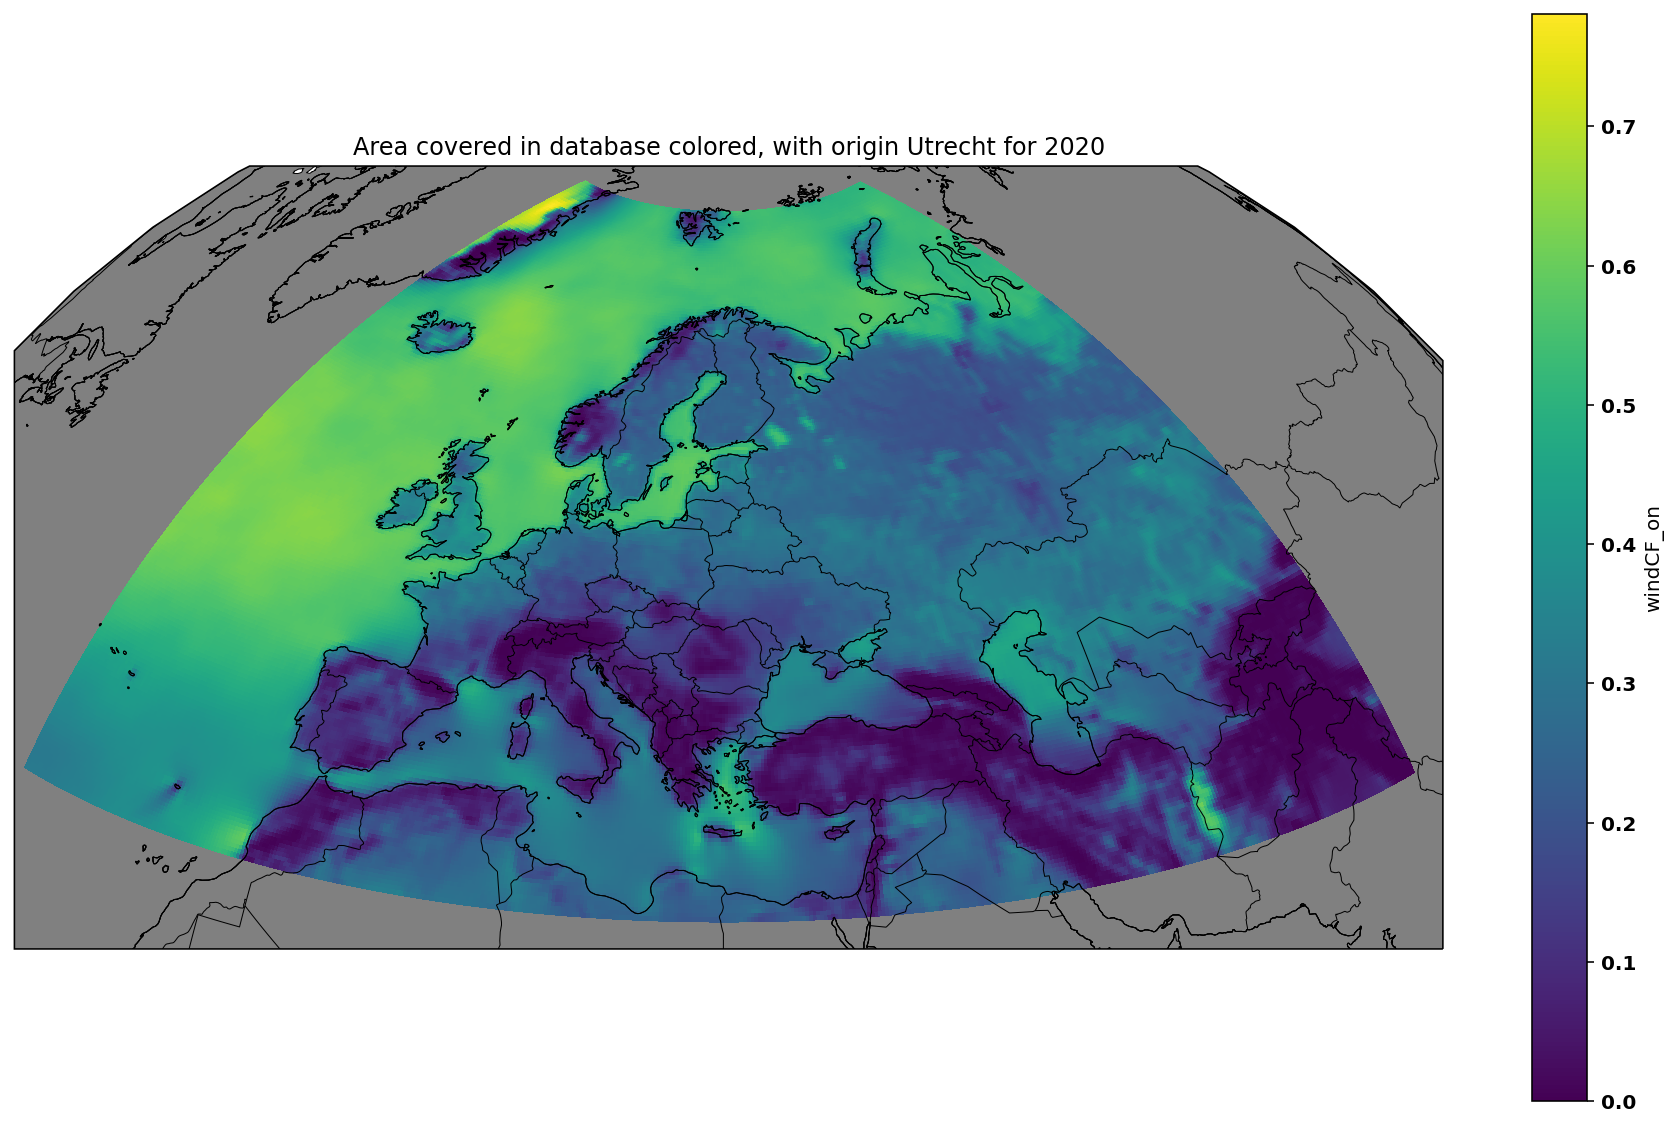

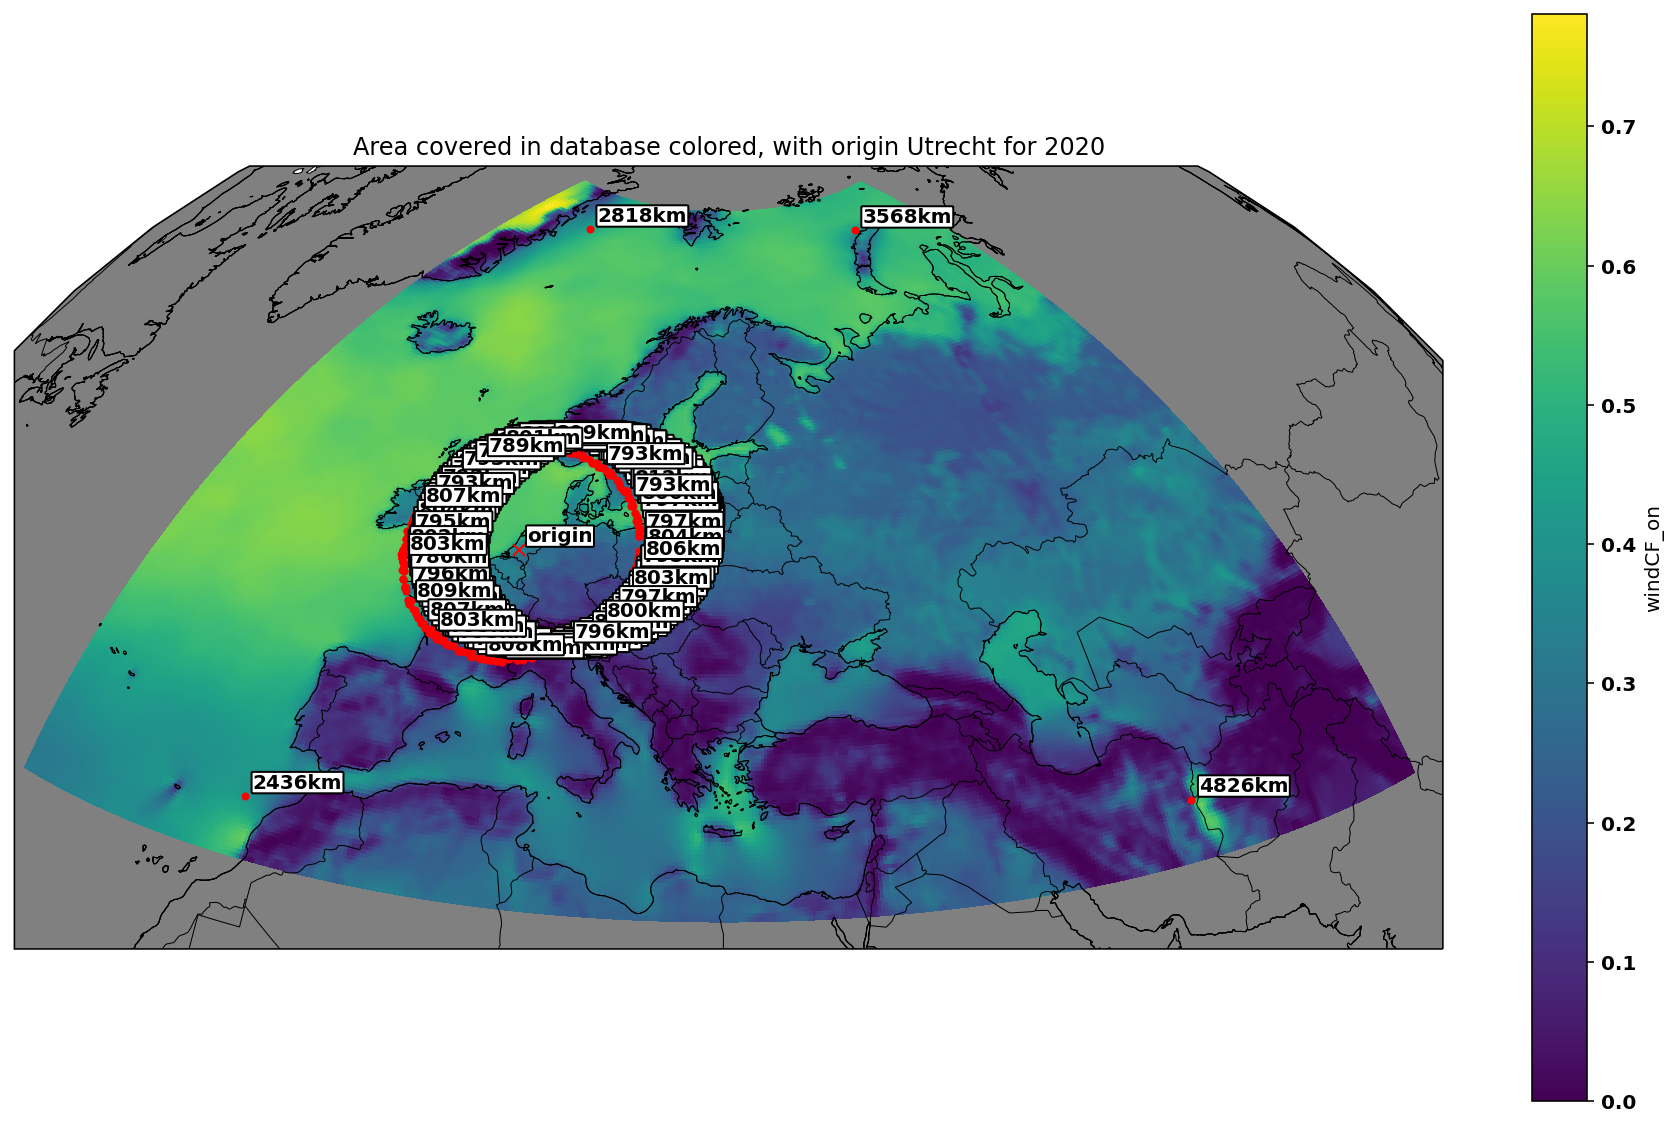

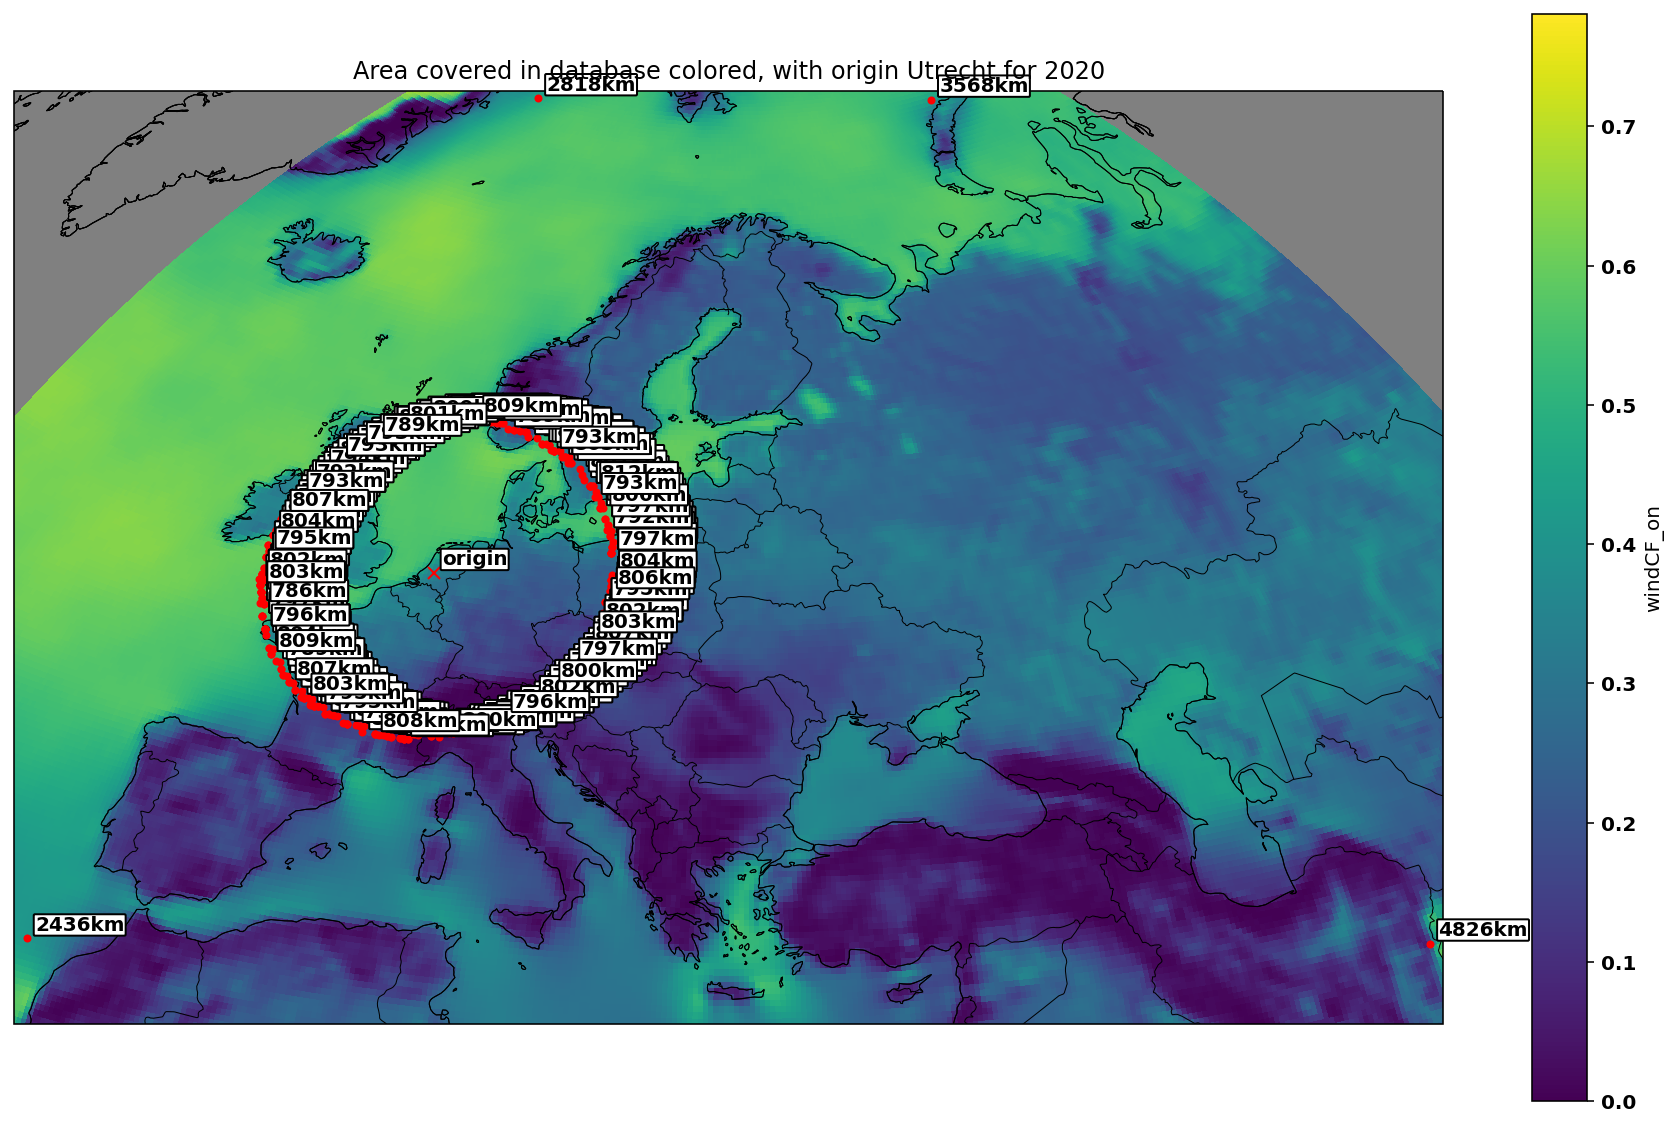

In [161]:
%matplotlib inline

#utrecht= (52.0907, 5.1214)
utrecht = (52.0,5.0)

amsterdam = (52.3676, 4.9041)
berlin = (52.5200, 13.4050)
florence = (43.7696,11.2558)
madrid = (40.4168, -3.7038)
zurich = (47.3769, 8.5417)


def rnd_dark():
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    # Return the color as an RGB tuple
    return (r/255, g/255, b/255)

#lat_min +=5
#lat_max -= 5
#lon_min += 5
#lon_max -=5

edges = [(lat_min+5, lon_min+5), (lat_max-5, lon_min+5), (lat_max-5, lon_max-5), (lat_min+5, lon_max-5)]
def gridPlot(origincell,samplelist):
    centerlat = (lat_min + lat_max) / 2
    centerlon = (lon_min + lon_max) / 2

    # the coordinates of utrecht
    #lat_utrecht, lon_utrecht = 52.0907, 5.1214

    #Plot the data map
    #solarCF = ds.solarCF
    time_idx = 12



    # Calculate the mean CF over time
    mean_windCF_on = ds.windCF_on.mean(dim='time')

    #Plot the mean CF using the calculated mean data
    p = mean_windCF_on.plot(
    #p = solarCF.isel(time=time_idx).plot( #one single timestamp
    transform=ccrs.PlateCarree(),
    subplot_kws={"projection": ccrs.Orthographic(centerlat-30, centerlon), "extent": (lon_min+5, lon_max-3, lat_min-10, lat_max+3)},
    #cmap=colors.ListedColormap(['white']),
    #add_colorbar=False,
    )

    ax = plt.gca()
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor='black', linewidth=0.5)

    ax.add_feature(cfeature.LAND.with_scale('50m'), linewidth=0.5, facecolor='gray', edgecolor='black', zorder=0)
    ax.add_feature(cfeature.OCEAN.with_scale('50m'), linewidth=0.5, facecolor='gray', edgecolor='black', zorder=0)


    #ax.plot(lon_utrecht, lat_utrecht, marker='x', color='red', markersize=7.5, alpha=1, transform=ccrs.PlateCarree())

    #time_string = pd.Timestamp(solarCF.time.values[time_idx]).strftime("%Y-%m-%d %H:%M:%S")
    p.axes.set_title("Area covered in database colored, with origin Utrecht for 2020")

    fig = plt.gcf()
    fig.set_size_inches(16, 10)
    fig.set_facecolor('white')

    return ax,fig,plt #return figure to be used in other functions

ax,fig,plt = gridPlot(utrecht,edges)
display(fig)

#Function to add markers to existing map
def addMarkers(ax,origin,lst):
    lst.append(origin)

    for i,pnt in enumerate(lst):
        if i == len(lst) - 1:
            dist_text = "origin"
            ax.plot(pnt[1], pnt[0], marker='x', color='red', markersize=6, transform=ccrs.PlateCarree())
        else:    
            dist_text = str(round(distance(utrecht,pnt).km)) + "km"
            ax.plot(pnt[1], pnt[0], marker='o', color='red', markersize=3, transform=ccrs.PlateCarree())
        ax.annotate(dist_text, xy=(pnt[1], pnt[0]), xytext=(4, 4), textcoords='offset points',transform=ccrs.PlateCarree(),bbox=dict(facecolor='white', edgecolor='black', pad=len(dist_text)*0.01, boxstyle='round'))
    #ax.plot([-180, 180], [76, 76], color='red', linestyle='--', transform=ccrs.PlateCarree())

    lst.pop()
        #set the extent of the axis object
        #ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

def zoom(ax, origin, lst):
    lon_pad = 0.5
    lat_pad = 0.5
    lst.append(origin)  #add it to list of markers temporarily 

    min_lon = min(lon for lat, lon in lst ) - lon_pad
    max_lon = max(lon for lat, lon in lst ) + lon_pad
    min_lat = min(lat for lat, lon in lst) - lat_pad
    max_lat = max(lat for lat, lon in lst) + lat_pad
    lst.pop() #remove origin from marker list

    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())



#Get all points around a given center
def getCirclePoints(center, distance_km):


    pointlst = []

    # Loop over bearings from 1 to 359 degrees
    for bearing in range(0, 360):
        #Calculate destination point using geopy.distance.distance() function
        destination = distance(kilometers=distance_km).destination(center, bearing)
        #Obtain actual existing coordinates in the database
        actualpoint = getActualCoords(destination.latitude,destination.longitude)
        pointlst.append((actualpoint[0], actualpoint[1]))

    # Return list of destination points
    return pointlst


#lst = getCirclePoints(utrecht,2000)

lst = []
rng = Generator(PCG64(seed=0))
for i in range(0,360):
    angle = rng.uniform(0, 360)
    lst.append(getLoc(utrecht[0],utrecht[1],800,angle))

#minlat=33.61, minlon=-11.18
#minlat=33.61, minlon=60.18
#minlat=76.42, minlon=-11.18
#minlat=76.42, minlon=60.18

lst.extend(newbounds)

addMarkers(ax,utrecht,lst)
display(fig)
zoom(ax,utrecht,lst)






In [117]:


#Original bounds
min_lat = 30.0
max_lat = 80.0
min_lon = -31.0
max_lon = 80.0


min_point = Point(min_lat, min_lon)
max_point = Point(max_lat, max_lon)


distance_threshold = 400  

# Calculate new bounds
new_min_point = distance(kilometers=distance_threshold).destination(min_point, 45)
new_max_point = distance(kilometers=distance_threshold).destination(max_point, 225)

#Ensure the new bounds stay within the original bounds
new_min_point = Point(max(new_min_point.latitude, min_lat), max(new_min_point.longitude, min_lon))
new_max_point = Point(min(new_max_point.latitude, max_lat), min(new_max_point.longitude, max_lon))


new_min_lat = new_min_point.latitude
new_max_lat = new_max_point.latitude
new_min_lon = new_min_point.longitude
new_max_lon = new_max_point.longitude
print("New Minimum Latitude:", new_min_lat)
print("New Maximum Latitude:", new_max_lat)
print("New Minimum Longitude:", new_min_lon)
print("New Maximum Longitude:", new_max_lon)


New Minimum Latitude: 32.51667005027706
New Maximum Latitude: 77.21585337771448
New Minimum Longitude: -27.99032559780926
New Maximum Longitude: 68.48424817455947


In [183]:
rng = Generator(PCG64(seed=int(originlat))) #seed generator for random values
originlat =  rng.uniform(latbounds400[0],latbounds400[1])
originlon = rng.uniform(latbounds400[0],latbounds400[1])
origin = getActualCoords(originlat,originlon)
print(origin)

(58.5, 56.25)


<h2>Uncertainty Sampling for given origin(s)</h2>

In [235]:
iterations = 1000 #max number of iterations in case stopping criteria is not reached
runs = 30
LowerBound = 100
UpperBound = 4000

#origin = (50.5,30.5) #near Madrid
#og0 = origin[0]
#og1 = origin[1]

#stopping criteria
stdSC = 17 
scdiff = 3
startcount = 1
maxcount = 3

Dhat_arr_lst = []
cov_arr_lst = []
x_lst = []
y_lst = []
locs_lst = []
time_lst = []
origin_lst = []

#origin_lst = [(47.5,8.5) for i in runs]
for aseed in range(0,runs):
    rng = Generator(PCG64(seed=aseed)) #seed generator for random values

    #Generate a random origin cell that is at least ~400km from all edges of the original database (and snapping to the closest existing point)
    originlat =  rng.uniform(latbounds400[0],latbounds400[1])
    originlon = rng.uniform(lonbounds400[0],lonbounds400[1])
    origin = getActualCoords(originlat,originlon)

    #Make sure origin wasn't already generated
    while origin in origin_lst:
        originlat =  rng.uniform(latbounds400[0],latbounds400[1])
        originlon = rng.uniform(lonbounds400[0],lonbounds400[1])
        origin = getActualCoords(originlat,originlon)

    #origin = (47.5,8.5) #zurich
    og0 = origin[0]
    og1 = origin[1]
    print(origin)
    origin_lst.append(origin)
    
    #Time the algorithm
    start_time = time.time()


    locLB = getLoc(og0,og1, LowerBound,rng.uniform(0, 360))
    locUB = getLoc(og0,og1,UpperBound,rng.uniform(0, 360))


    rp0 = rng.uniform(100, 1000) #sample initial random guess of D-hat for curve fitting

    Dhat_arr = []
    cov_arr = []

    rhoLB = pairCorrelation(origin,locLB) #get corr.
    rhoUB = pairCorrelation(origin,locUB)

    x = [LowerBound,UpperBound] #add distances from origin point to this list
    y = [rhoLB,rhoUB] #store corresponding rho values in y list
    locs = [locLB,locUB]

    q2 = 0.5* (LowerBound+UpperBound)
    locq2 = getLoc(og0,og1, 0.5* (LowerBound+UpperBound) ,rng.uniform(0, 360))
    rhoq2 = pairCorrelation(origin,locq2)

    x.append(q2)
    y.append(rhoq2)
    locs.append(locq2)

    #Filter out NaN values before function fit
    mask = np.logical_not(np.isnan(y))
    x = [x[i] for i in range(len(x)) if mask[i]]
    y = [y[i] for i in range(len(y)) if mask[i]]
    locs = [locs[i] for i in range(len(locs)) if mask[i]]
    params, covs = optimize.curve_fit(cordist, xdata = x, ydata = y, p0=rp0) #fit the curve onto the 2 data points and get D-hat and covariance estimates


    Dhat_arr.append(params[0]) #new estimate of correlation distance, D-hat
    cov_arr.append(sqrt(covs[0][0]))

    i_arr = [0]  #used as x axis to plot iteration number. the loop will start from iteration no. 1(not 0) and the list will be updated each time.


    for i in range(0,iterations):
            i_arr.append(i+1) #update every iteration

            sf = (1.5)
            for j in range(0,4): #take 4 points per iteration
                
                #print("scalefactor",sf)
                b =  Dhat_arr[i-1] + sf * cov_arr[i-1] #the two interval bounds
                a =  Dhat_arr[i-1] - sf * cov_arr[i-1]

                #if a is negative, take 4 random points and move to next iteration of loop to prevent NaN error
                if a < 0: 

                    for k in range(0,4-j): #only take as many random points as needed
                        d = rng.uniform(LowerBound,UpperBound)
                        loc_d = getLoc(og0,og1, d ,rng.uniform(0, 360))
                        #if location already sampled, regenerate location with a different angle
                        counter = 0
                        while loc_d in locs:
                            loc_d = getLoc(og0,og1, d ,rng.uniform(0, 360))
                            counter +=1
                            if(counter > 360):
                                d = rng.uniform(LowerBound,UpperBound)
                                loc_d = getLoc(og0,og1, d ,rng.uniform(0, 360))

                        rhod = pairCorrelation(origin,loc_d)
                        x.append(d)
                        y.append(rhod)
                        locs.append(loc_d)
                    break
                    
                d = - (a*b*np.log(a/b)) / (np.log(2)*(b-a)) #get the max. distance between the curves; natural log by default for numpy
                loc_d = getLoc(og0,og1, d ,rng.uniform(0, 360))

                counter = 0
                while loc_d in locs:
                    loc_d = getLoc(og0,og1, d ,rng.uniform(0, 360))
                    counter +=1
                    if(counter > 360):
                        d = rng.uniform(LowerBound,UpperBound)
                        loc_d = getLoc(og0,og1, d ,rng.uniform(0, 360))

                rhod = pairCorrelation(origin,loc_d)
                x.append(d)
                y.append(rhod)
                locs.append(loc_d)
                sf+= 0.5 

            
            #Filter out NaN values before function fit
            mask = np.logical_not(np.isnan(y))
            x = [x[i] for i in range(len(x)) if mask[i]]
            y = [y[i] for i in range(len(y)) if mask[i]]
            locs = [locs[i] for i in range(len(locs)) if mask[i]]
            params, covs = optimize.curve_fit(cordist, xdata = x, ydata = y, p0=rp0) #fit the curve onto the 2 data points and get D-hat and covariance estimates
            Dhat_arr.append(params[0]) #new estimate of correlation distance, D-hat
            cov_arr.append(sqrt(covs[0][0]))

            #triple s.c. -> past 10 iterations, if |Dhat - prev Dhat| < 3km for at least 3 iters, and s.d. < 17km, then stop
            if(i > 10 ):
                absdiff = abs(params[0] - Dhat_arr[-2]) #estimate difference between current and previous iteration
                if (absdiff < scdiff):
                    startcount+=1
                else:
                    startcount = 0

                if (startcount >= maxcount and cov_arr[-1]<stdSC): 
                    #print("stopping criteria reached")

                    break #end the algorithm in this case
    #Save data per run
    Dhat_arr_lst.append(Dhat_arr)
    cov_arr_lst.append(cov_arr)
    x_lst.append(x)
    y_lst.append(y)
    locs_lst.append(locs)
    elapsed_time = time.time() - start_time
    time_lst.append(elapsed_time)



(61.0, 8.0)
(55.5, 56.75)
(44.75, 10.0)
(37.25, 5.75)
(74.0, 25.25)
(68.0, 46.5)
(56.75, 13.25)
(60.5, 53.0)
(47.5, 59.25)
(71.0, 9.25)
(74.5, 3.5)
(39.0, 24.5)
(44.25, 56.5)
(70.75, 50.0)
(69.25, 14.5)
(63.25, 47.0)
(58.0, 19.5)
(69.75, 0.25)
(50.75, 40.0)
(51.5, 55.0)
(45.5, 21.75)
(67.0, 32.0)
(49.25, 3.0)
(63.25, 34.5)
(47.75, 17.75)
(40.5, -11.25)
(54.75, 5.5)
(63.5, 11.25)
(70.25, 52.0)
(35.75, 25.0)


In [236]:
#print(x)
#print(len(x_lst[0]),len(x_lst[1]))
print ([lst[-1] for lst in Dhat_arr_lst])
print("average no. of samples for Uncertainty over :",np.mean([len(lst) for lst in np.array(x_lst, dtype=object)], axis=0))

corrdistances = [lst[-1] for lst in Dhat_arr_lst]
meanCorrelationDistance = np.mean(corrdistances)
print("Average correlation distance over {} runs:".format(runs),meanCorrelationDistance,"km")
print("Average time taken:", np.mean(time_lst)," seconds")
#Save samples and locations


[236.83099039840403, 470.36431855040445, 109.79274448158763, 225.0094384742482, 244.512487841281, 317.170497283463, 459.14928120777364, 483.874066844625, 378.8902498604229, 260.2264233682627, 243.59474515871636, 199.78640312020218, 344.2456256882489, 276.51229651291465, 236.77371121535836, 446.8883903451415, 408.46498457689563, 259.6082055159265, 391.4278025341865, 397.5197511350584, 180.01304615511523, 369.499014203478, 405.67452499089507, 478.8407013953805, 290.6002405075562, 307.4959492766883, 370.1883789855234, 281.94612048110355, 277.5245215345335, 173.08500044885918]
average no. of samples for Uncertainty over : 63.4
Average correlation distance over 30 runs: 317.51699706974176 km
Average time taken: 72.44136118094126  seconds


In [237]:

#Get all points at correlation distance at all whole number angles in degrees to get 360 points

mean_correlations = []

for i in range(0,len(origin_lst)):
    allpoints =  getCirclePoints(origin_lst[i], corrdistances[i])
    uniquepoints = list(set(allpoints)) #remove duplicates
    correlationvalues = []

    #Calculate correlation between origin and each other point in the circle
    for p in uniquepoints:
        correlationvalues.append(pairCorrelation(origin_lst[i],p))
    #Append the mean value to the list
    mean_correlations.append(np.mean(correlationvalues))

print("first check done")

mean_correlations_small = []
mean_correlations_big = []


#For each run, take circles that are corrdist +- 2 stdeviations and do the validation check on both.
for i in range(len(cov_arr_lst)):
    smallcircle = list(set(getCirclePoints(origin_lst[i], corrdistances[i] - 2 * cov_arr_lst[i][-1])))
    bigcircle = list(set(getCirclePoints(origin_lst[i], corrdistances[i] + 2 * cov_arr_lst[i][-1])))

    small_corr_vals =[]
    big_corr_vals = []

    for p1 in smallcircle:
        small_corr_vals.append(pairCorrelation(origin_lst[i],p1))
    mean_correlations_small.append(np.mean(small_corr_vals))

    for p2 in bigcircle:
        big_corr_vals.append(pairCorrelation(origin_lst[i],p2))
    mean_correlations_big.append(np.mean(big_corr_vals))




filename = 'results2020__randomorigins__' + str(runs) + 'runs.pkl'
with open(filename, 'wb') as f:
    #Use this order when loading from file to know which number is which;
    pickle.dump((x_lst, y_lst, locs_lst,Dhat_arr_lst,cov_arr_lst,time_lst,mean_correlations,mean_correlations_small,mean_correlations_big,corrdistances,origin_lst), f)

print("Mean across {} runs of mean correlation at correlation distance: ".format(runs),np.mean(mean_correlations))
print("Mean across {} runs of mean correlation at correlation distance - 2 st. deviations: ".format(runs),np.mean(mean_correlations_small))
print("Mean across {} runs of mean correlation at correlation distance + 2 st. deviations: ".format(runs),np.mean(mean_correlations_big))


first check done
Mean across 30 runs of mean correlation at correlation distance:  0.49702118572456155
Mean across 30 runs of mean correlation at correlation distance - 2 st. deviations:  0.517949289971574
Mean across 30 runs of mean correlation at correlation distance + 2 st. deviations:  0.47740900670282227


In [238]:
for i in range(0,len(corrdistances)):
    print(origin_lst[i],corrdistances[i])

(61.0, 8.0) 236.83099039840403
(55.5, 56.75) 470.36431855040445
(44.75, 10.0) 109.79274448158763
(37.25, 5.75) 225.0094384742482
(74.0, 25.25) 244.512487841281
(68.0, 46.5) 317.170497283463
(56.75, 13.25) 459.14928120777364
(60.5, 53.0) 483.874066844625
(47.5, 59.25) 378.8902498604229
(71.0, 9.25) 260.2264233682627
(74.5, 3.5) 243.59474515871636
(39.0, 24.5) 199.78640312020218
(44.25, 56.5) 344.2456256882489
(70.75, 50.0) 276.51229651291465
(69.25, 14.5) 236.77371121535836
(63.25, 47.0) 446.8883903451415
(58.0, 19.5) 408.46498457689563
(69.75, 0.25) 259.6082055159265
(50.75, 40.0) 391.4278025341865
(51.5, 55.0) 397.5197511350584
(45.5, 21.75) 180.01304615511523
(67.0, 32.0) 369.499014203478
(49.25, 3.0) 405.67452499089507
(63.25, 34.5) 478.8407013953805
(47.75, 17.75) 290.6002405075562
(40.5, -11.25) 307.4959492766883
(54.75, 5.5) 370.1883789855234
(63.5, 11.25) 281.94612048110355
(70.25, 52.0) 277.5245215345335
(35.75, 25.0) 173.08500044885918


In [239]:

print(f"Mean across 10 runs of mean correlation at correlation distance: ",np.mean(mean_correlations))
print(f"Mean across 10 runs of mean correlation at correlation distance - 2 st. deviations: ",np.mean(mean_correlations_small))
print(f"Mean across 10 runs of mean correlation at correlation distance + 2 st. deviations: ",np.mean(mean_correlations_big))




Mean across 10 runs of mean correlation at correlation distance:  0.49702118572456155
Mean across 10 runs of mean correlation at correlation distance - 2 st. deviations:  0.517949289971574
Mean across 10 runs of mean correlation at correlation distance + 2 st. deviations:  0.47740900670282227


font = {
        'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)


plt.figure(8)
plt.plot(i_arr,Dhat_arr, c='red')#,label='Uncertainty sampling' ) #systematic random
plt.axhline(y=Dhat_arr[-1], color='gray', linestyle='--')
plt.ylabel('($\hat{D}$) (km)')
plt.xlabel('Iteration')  

plt.figure(9)
plt.plot(i_arr,cov_arr, c='blue')#,label='Un' ) #systematic random
plt.axhline(y=25, color='gray', linestyle='--')
plt.axhline(y=17, color='gray', linestyle='--')
plt.axhline(y=10, color='gray', linestyle='--')
plt.ylabel('Standard Deviation estimate (km)') 
plt.xlabel('Iteration')  
#plt.xlim(0,100)


plt.figure(11)
plt.scatter(x,y,color='purple')#,label='U\'s Sampled Distances'


plt.ylabel('Correlation')
plt.xlabel('Sampled distance(km)')  


<h2>Plot Centers with Correlation Distances</h2>

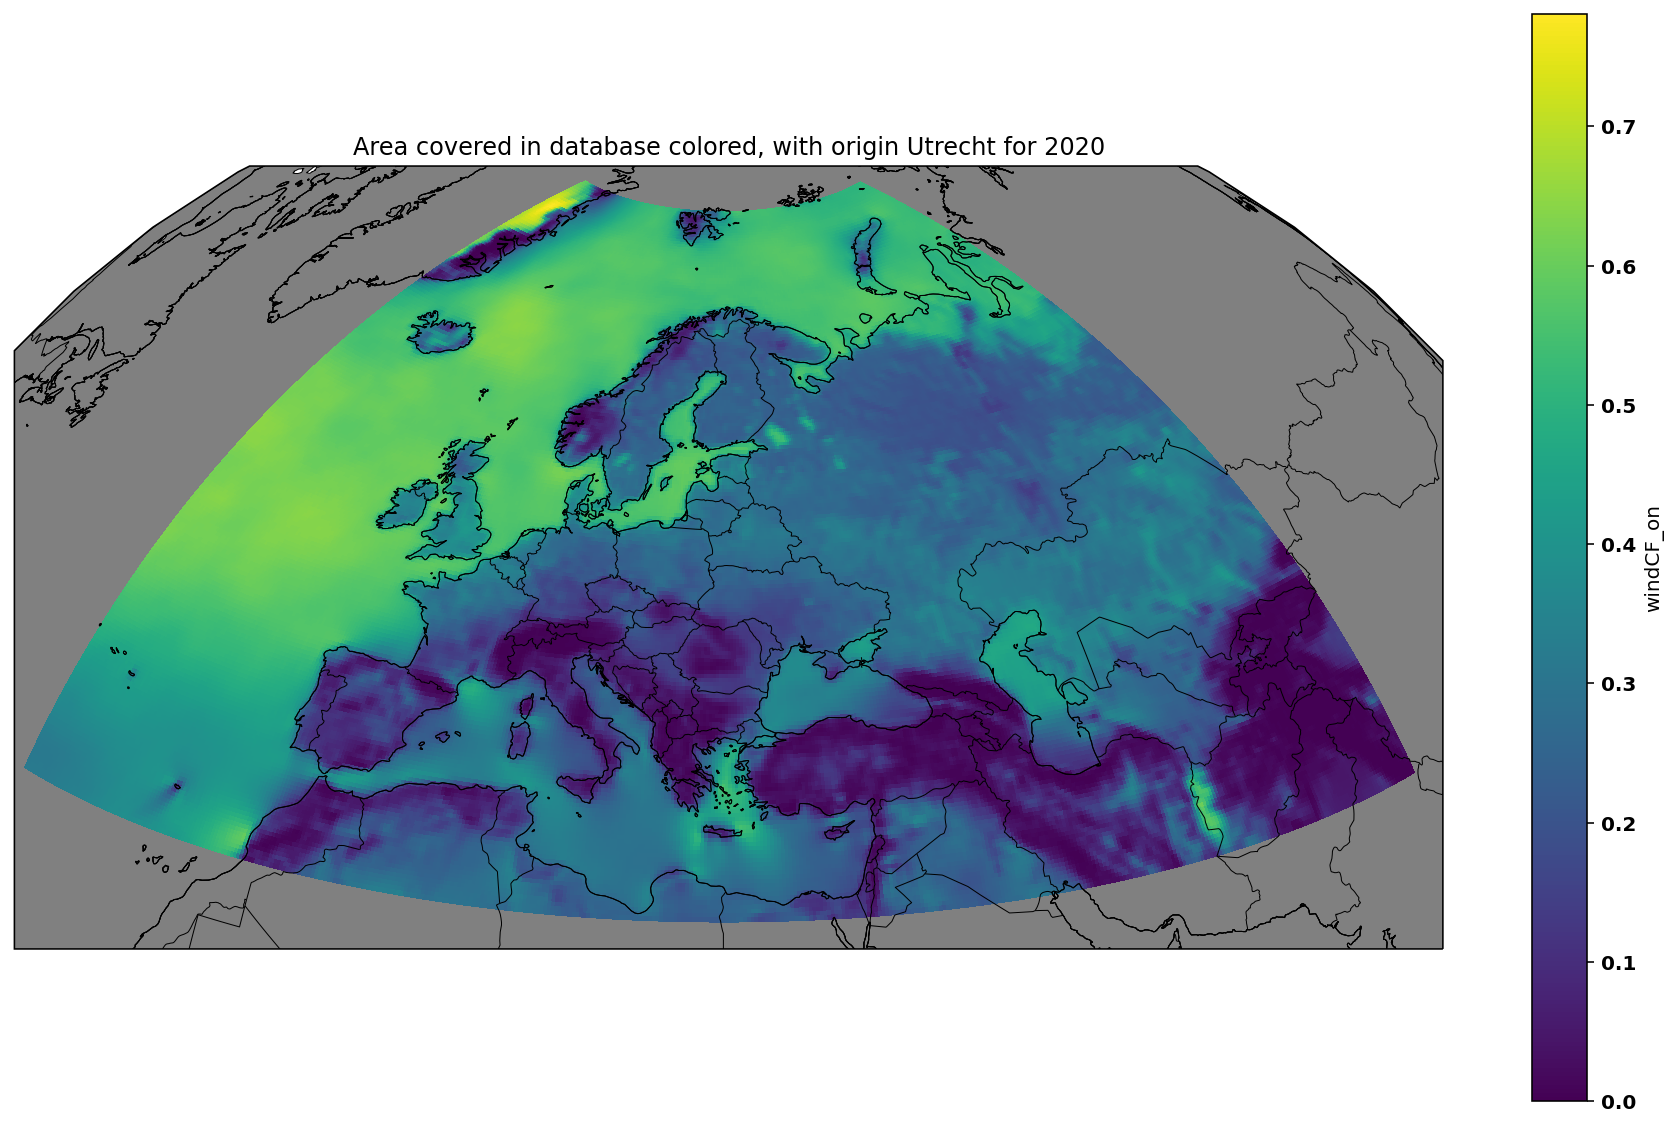

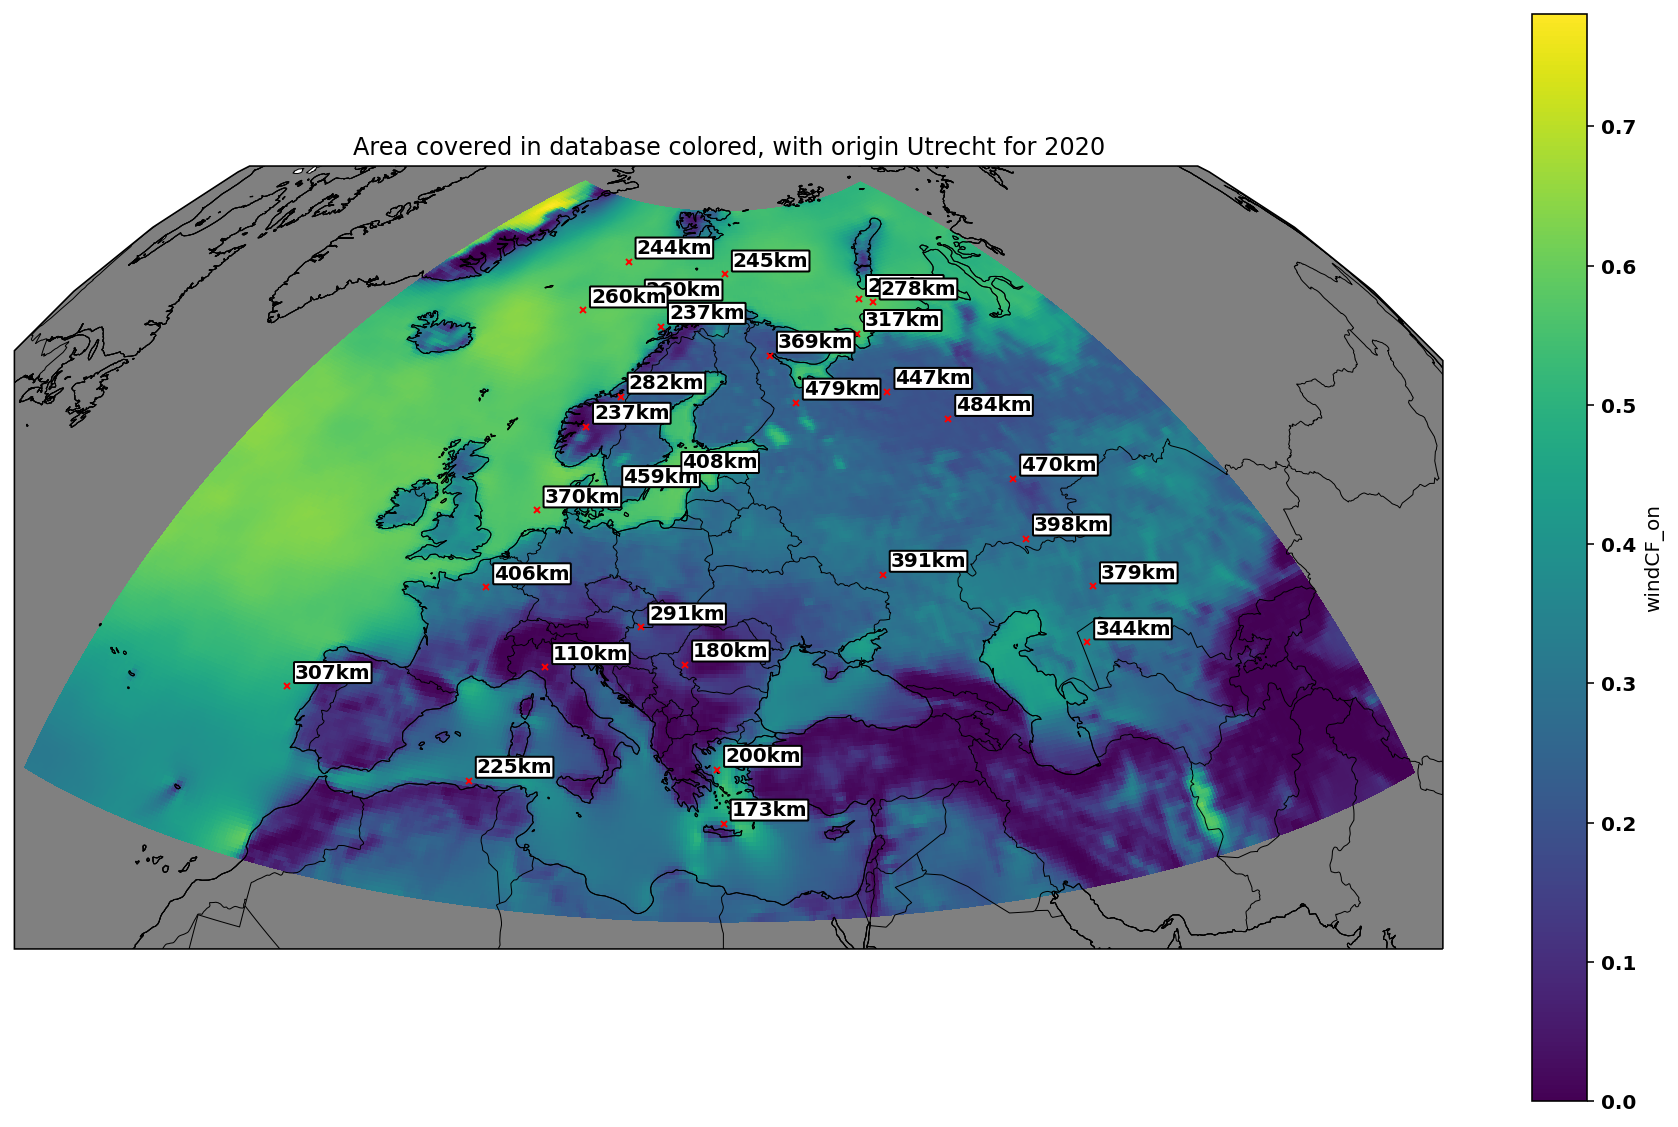

In [246]:

ax,fig,plt = gridPlot(utrecht,edges)
display(fig)

for i,pnt in enumerate(origin_lst):
        dist_text = str(round(corrdistances[i])) + "km"
        ax.plot(pnt[1], pnt[0], marker='x', color='red', markersize=3, transform=ccrs.PlateCarree())
        ax.annotate(dist_text, xy=(pnt[1], pnt[0]), xytext=(4, 4), textcoords='offset points',transform=ccrs.PlateCarree(),bbox=dict(facecolor='white', edgecolor='black', pad=len(dist_text)*0.01, boxstyle='round'))
    #ax.plot([-180, 180], [76, 76], color='red', linestyle='--', transform=ccrs.PlateCarree())




<h2>Validation</h2>

In [241]:
adjacent_point = ds.sel(latitude=(50.4501), longitude= 30.5234, method='nearest')

print(adjacent_point)

<xarray.Dataset>
Dimensions:     (time: 8784)
Coordinates:
    longitude   float32 30.5
    latitude    float32 50.5
  * time        (time) datetime64[ns] 2020-01-01 ... 2020-12-31T23:00:00
Data variables:
    solarCF     (time) float32 dask.array<chunksize=(744,), meta=np.ndarray>
    windCF_off  (time) float32 dask.array<chunksize=(744,), meta=np.ndarray>
    windCF_on   (time) float32 dask.array<chunksize=(744,), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2021-12-24 19:52:30 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...
    author:       Laurens Stoop UU/KNMI/TenneT
    created:      27-01-2022
    map_area:     Europe
    data_source:  ERA5 reanalysis data, contains modified Copernicus Climate ...


In [242]:

x=[100, 4000, 2050.0]
y = [0.9341548567678795, np.nan, 0.02543356037524947]
locs = [(50.0, 29.5), (35.25, 76.0), (68.75, 35.75)]

mask = np.logical_not(np.isnan(y))

# Assign the filtered values back to x, y, and locs
x = [x[i] for i in range(len(x)) if mask[i]]
y = [y[i] for i in range(len(y)) if mask[i]]
locs = [locs[i] for i in range(len(locs)) if mask[i]]

print(x,y,locs)

[100, 2050.0] [0.9341548567678795, 0.02543356037524947] [(50.0, 29.5), (68.75, 35.75)]


In [243]:
#print(allpoints)
for coord in uniquepoints:
    dist = distance(utrecht, coord).kilometers
    print(f"Distance between {utrecht} and {coord}: {dist} km")

Distance between (52.0, 5.0) and (35.5, 23.25): 2335.892104847461 km
Distance between (52.0, 5.0) and (35.5, 23.0): 2323.7053429422713 km
Distance between (52.0, 5.0) and (35.5, 26.75): 2516.3410452506123 km
Distance between (52.0, 5.0) and (34.5, 24.0): 2466.2466674235607 km
Distance between (52.0, 5.0) and (37.25, 25.5): 2293.8385897992584 km
Distance between (52.0, 5.0) and (37.25, 25.75): 2307.4951059556206 km
Distance between (52.0, 5.0) and (37.25, 25.0): 2266.7719106152294 km
Distance between (52.0, 5.0) and (37.25, 25.25): 2280.263657717537 km
Distance between (52.0, 5.0) and (34.25, 26.0): 2589.9998074806554 km
Distance between (52.0, 5.0) and (35.75, 27.0): 2507.694999867889 km
Distance between (52.0, 5.0) and (37.0, 24.0): 2236.1188437005803 km
Distance between (52.0, 5.0) and (36.25, 23.25): 2266.2494888159517 km
Distance between (52.0, 5.0) and (36.25, 26.75): 2449.9155188792442 km
Distance between (52.0, 5.0) and (35.0, 23.5): 2394.9102653001646 km
Distance between (52.0,

take 2 more circles at (Dhat +- 2* final std.) and check for the small circle if corr > 0.5, and for the big one corr < 0.5.

run 10x for utrecht with different seeds and check how different the corridst values are (check variation in corr dist).

run 10x - 1000x for different  (random) centers.

one point per distance in a random direction.

to evaluate -> check correlation at CD given by model. take lat,lon by taking every  degree in a "circle", making sure each coord is taken only once.

for map, plot avg (mean) values of solar (or wind) cf.

for solar mean, do groupby of the hour of the day (eg only take timestamps that are 12pm)

always take 4 sample grid cells. if you have a given sample distance, 

In [244]:
with open('results2020__47pnt5_8pnt5__10x.pkl', 'rb') as file:
    data = pickle.load(file)

#Access correlation distances for 10 runs for zurich as center
print(data[9])


[214.32358467001427, 159.52950862155112, 202.75125755922585, 183.41778613017613, 140.10841371766102, 240.68453792341052, 133.7208734555915, 142.38253848023683, 110.14172184914524, 186.7357653915619]
